In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities_visualization
from process_movella import load_movella, get_position
from utilities_hula_hoop import get_steady_hooping_interval, get_fixed_frame_acceleration

# Load Data

In [2]:
IN_DIRS = [
    Path("uploads/2025-10-01 Experiment 6/2025-10-01 Quaternions"),
    Path("uploads/2025-10-01 Experiment 6/2025-10-01 Euler Angles"),
    ]

In [3]:
# Reading sensor data
sensor_ids = ['OR','OL','IB','IT','IL']
quantities = ['time','ax','ay','az','phi','theta','psi','wx','wy','wz']
sensors = {
    'OR': 'hoop',
    'OL': 'waist',
    'IB': 'hip',
    'IT': 'knee',
    'IL': 'ankle'
}

test_file_paths = sorted(list(IN_DIRS[0].glob("OR_*.csv")))
n_recordings = len(test_file_paths)
for i in range(n_recordings):
    data_shapes = np.zeros((2,5,2))
    for j,in_dir in enumerate(IN_DIRS):
        files = {
            sid : sorted(list(in_dir.glob(f"{sid}_*.csv")))[i]
            for sid in sensor_ids
        }
        raw_data = {
            sid: load_movella(files[sid], lead_time=0)
            for sid in sensor_ids
        }
        
        data_shapes[j] = [d.shape for d in raw_data.values()]
        
        raw_data_dict = {}

        for sid in sensor_ids:
            array = raw_data[sid]
            raw_data_dict[sid] = {q: array[:,i] for i,q in enumerate(quantities)}
            raw_data_dict[sid]['amag'] = np.sqrt(raw_data_dict[sid]['ax']**2 + raw_data_dict[sid]['ay']**2)

        # time step
        dt = raw_data_dict['OR']['time'][1]-raw_data_dict['OR']['time'][0]
        
        # show a table of the data
        # print("Raw Data; Local Axes")
        # pd.DataFrame(raw_data_dict)
    assert all(data_shapes[j][k][l] == data_shapes[j][0][l] for k in range(5) for l in range(2)), f"{data_shapes=}, {test_file_paths[i]=}"


In [4]:
data = np.vstack([raw_data_dict[sensor_id][quantity]
                        for sensor_id in sensor_ids
                        for quantity in quantities[1:]])
print(f"{data.shape=}")
# np.save("data_experiment_test.npy", data)

data.shape=(45, 3420)


# Raw Data in the local axes

In [5]:
sensor_titles = [sensors[sid] for sid in sensor_ids]
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'psi': 'rgba(0, 0, 255, 0.7)','theta': 'rgba(255, 0, 0, 0.7)','phi': 'rgba(0, 128, 0, 0.7)'}
legend_shown = {'psi': False, 'theta': False, 'phi': False}

for i,sid in enumerate(sensor_ids, start=1):
    for angle_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][angle_type], 
            mode='lines', 
            name=angle_type,
            legendgroup=f'{angle_type}',
            line=dict(color=color),
            showlegend=not legend_shown[angle_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[angle_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Euler Angle Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [6]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
colors = {'ax': 'rgba(0, 0, 255, 0.7)','ay': 'rgba(255, 0, 0, 0.7)','az': 'rgba(0, 128, 0, 0.7)', 'amag': 'rgba(128, 0, 128, 0.8)'}
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=raw_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Raw Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

# Steady Hooping Interval

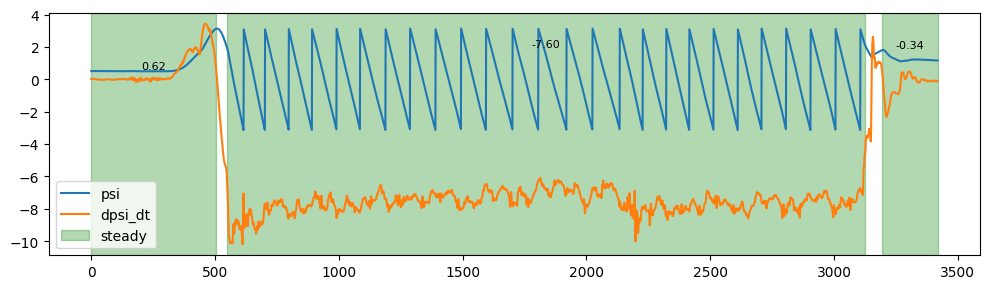

In [7]:
OR_groups, OR_averages = get_steady_hooping_interval(raw_data_dict['OR']['psi'], dt=dt, threshold=0.8)
t_active = OR_groups[1]
active_slice = slice(*t_active)

# Fixed Frame Data

In [8]:
fixed_data_dict = {}
accels = ['ax','ay','az']
for sid in sensor_ids:
    fixed_a = get_fixed_frame_acceleration(raw_data_dict[sid]['ax'], raw_data_dict[sid]['ay'], raw_data_dict[sid]['az'],
                                           raw_data_dict[sid]['psi'], raw_data_dict[sid]['theta'], raw_data_dict[sid]['phi'])
    fixed_data_dict[sid] = {a:fixed_a[i] for i,a in enumerate(accels)}
    fixed_data_dict[sid]['amag'] = np.sqrt(fixed_data_dict[sid]['ax']**2 + fixed_data_dict[sid]['ay']**2)

In [9]:
positions_velocities = ['dx','dy','dz','vx','vy','vz']
for sid in sensor_ids:
    array = get_position(raw_data_dict[sid]['time'],fixed_data_dict[sid]['ax'],fixed_data_dict[sid]['ay'],fixed_data_dict[sid]['az'],
                         degree=20,initial=0)
    for i,pv in enumerate(positions_velocities):
        fixed_data_dict[sid][pv] = array[i]

print("Fixed Frame Data")
pd.DataFrame(fixed_data_dict)

Fixed Frame Data


OR  \
ax    [0.11954309143330936, 0.07043247011444265, -0....   
ay    [0.1200765246349148, 0.21019539365033024, 0.20...   
az    [-0.03805861049352198, 0.01718376298543448, 0....   
amag  [0.16943707527525334, 0.2216818358779969, 0.20...   
dx    [-0.09341506031031999, -0.08260851372914561, -...   
dy    [0.2135357954120203, 0.18039379491209698, 0.14...   
dz    [-0.1463292108493671, -0.12579253987614733, -0...   
vx    [-0.08341312596036765, -0.0669508684558649, -0...   
vy    [-0.8311716215359826, -0.725233230856204, -0.6...   
vz    [0.30849868207015785, 0.26834701204127465, 0.2...   

                                                     OL  \
ax    [0.25411068058843894, 0.22920788881235818, 0.2...   
ay    [-0.14783817260954535, -0.06774875926687238, -...   
az    [0.02055134817283322, -0.09520316890823999, -0...   
amag  [0.29398701207646805, 0.23901077522994435, 0.2...   
dx    [0.12989380354823996, 0.11350205755164681, 0.0...   
dy    [0.014608556786198101, 0.013496436042224773, 0...   
dz    [0.006109844013288268, 0.005377636923589514, 0...   
vx    [-0.04980305332600832, -0.04855477150855078, -...   
vy    [0.08353175776559985, 0.07007909429050277, 0.0...   
vz    [0.0025243802336222254, 0.0014943286786587517,...   

                                                     IB  \
ax    [-0.0005695407341096137, -0.003516351783474054...   
ay    [-0.07112360151923333, -0.04603100005465537, 0...   
az    [-0.014217874082665578, 0.01152953085869959, -...   
amag  [0.07112588185544345, 0.046165113407169535, 0....   
dx    [0.07955409915044404, 0.06814973975331552, 0.0...   
dy    [0.016468608541458915, 0.013886617147290134, 0...   
dz    [-0.0032070468401458048, -0.002653747631522438...   
vx    [-0.1962151859703649, -0.17129594780632765, -0...   
vy    [-0.06736755154339047, -0.058469191780271955, ...   
vz    [0.019316155733481333, 0.016549439288334442, 0...   

                                                     IT  \
ax    [0.016748861006944366, -0.005327641626891616, ...   
ay    [0.024319306114336373, 0.02119083914102747, 0....   
az    [-0.028233730605486895, -0.04916164358511944, ...   
amag  [0.02952885021318541, 0.021850295851669612, 0....   
dx    [-0.03585700017818909, -0.03050973490883443, -...   
dy    [0.0056976743622341505, 0.005396821715318485, ...   
dz    [0.010171156631393011, 0.009224473320297001, 0...   
vx    [0.1129837292057072, 0.09931903717989252, 0.08...   
vy    [0.05005133984690957, 0.03957813980743033, 0.0...   
vz    [0.037956798150523774, 0.030034702048434773, 0...   

                                                     IL  
ax    [0.07611071029592435, 0.0491237271736579, 0.01...  
ay    [-0.006273455173372595, -0.031282136899913666,...  
az    [0.011894719206219127, 0.028714066478451268, 0...  
amag  [0.07636881864715757, 0.05823841224189509, 0.0...  
dx    [-0.03919982745150938, -0.03379332256383792, -...  
dy    [-0.028647987874142036, -0.026905351929795193,...  
dz    [-0.01430423739358672, -0.011818329277351942, ...  
vx    [0.07054531511353423, 0.06261690374054539, 0.0...  
vy    [-0.2153814901193032, -0.1845222851872637, -0....  
vz    [0.08766524587830227, 0.07646411980135591, 0.0...

In [10]:
fig = make_subplots(rows=len(sensor_titles), cols=1, subplot_titles=sensor_titles)
legend_shown = {'ax': False, 'ay': False, 'az': False, 'amag': False}

for i,sid in enumerate(sensor_ids, start=1):
    for a_type,color in colors.items():
        fig.add_trace(go.Scatter(
            x=raw_data_dict[sid]['time'], 
            y=fixed_data_dict[sid][a_type], 
            mode='lines', 
            name=a_type,
            legendgroup=a_type,
            line=dict(color=color,width=1),
            showlegend=not legend_shown[a_type]
        ), row=i, col=1)
        # Mark this legend item as shown after the first trace
        legend_shown[a_type] = True

# Decrease margins and add a title
fig.update_layout(
    height=800,width=800,
    title_text="Fixed Frame Acceleration Data",
    margin=dict(l=40, r=20, t=80, b=40),
)
fig.show()

In [11]:
fig_hooppath = go.Figure()
fig_hooppath.add_trace(go.Scatter3d(x=fixed_data_dict['OR']['dx'], y=fixed_data_dict['OR']['dy'], z=fixed_data_dict['OR']['dz'], mode='lines', name='hoop'))
fig_hooppath.update_layout(height=500,width=600,
    title_text="Hoop Sensor Displacement"
)
fig_hooppath.show()